In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, binary_erosion
import copy

import cc3d
import torch

from monai.metrics import compute_iou
import torch.nn.functional as F

from monai.metrics import DiceMetric, HausdorffDistanceMetric, SurfaceDiceMetric, SurfaceDistanceMetric

from scipy.ndimage import distance_transform_edt

#from panoptic_measure import panoptic_quality
from scipy.ndimage import label
from skimage.metrics import adapted_rand_error

import nibabel as nib

import gc
import os

In [3]:
def compute_all_metrics(cc_labels, array, s, drop_cc=False, caching_dir=".",caching_name="toy1.npy"):
    cc_dt = []

    if not drop_cc and os.path.exists(os.path.join(caching_dir,caching_name)):
        cc_asignment = np.load(os.path.join(caching_dir,caching_name))
    else:
        for cc in np.unique(cc_labels):
            if cc == 0:
                pass
            else:
                cc_dt.append(
                    distance_transform_edt(np.logical_not(cc_labels == cc)).astype(np.float32) 
                    #Convert to float 32 due to 64GB Ram limitation
                    )
        cc_asignment = np.argmin(np.stack(cc_dt),axis=0)+1
    if drop_cc:
        np.save(os.path.join(caching_dir,caching_name),cc_asignment)    
    original_labels = torch.from_numpy(array)
    cc_asignment = torch.from_numpy(cc_asignment)


    scenario_predictions = torch.from_numpy(s)
    
    cur_pred = F.one_hot(scenario_predictions.unsqueeze(0).long(),num_classes=2)
    cur_pred = cur_pred.permute(0,4,1,2,3)
    cur_labels = F.one_hot(original_labels.unsqueeze(0).long(),num_classes=2)
    cur_labels = cur_labels.permute(0,4,1,2,3)
    cur_cc_asignment = cc_asignment.unsqueeze(0)
    
    metrics = {
        "DiceMetric": DiceMetric(include_background=False, reduction="mean"),
        "HausdorffDistance": HausdorffDistanceMetric(include_background=False, distance_metric='euclidean', percentile=None, directed=False, reduction='mean', get_not_nans=False),
        "HausdorffDistance95": HausdorffDistanceMetric(include_background=False, distance_metric='euclidean',percentile=95, directed=False, reduction='mean', get_not_nans=False),
        "SurfaceDistance": SurfaceDistanceMetric(include_background=False, symmetric=False, distance_metric='euclidean', reduction='mean', get_not_nans=False),
        "SurfaceDiceMetric": SurfaceDiceMetric(class_thresholds=[1] ,include_background=False, distance_metric='euclidean', reduction='mean', get_not_nans=False, use_subvoxels=False),
    }
    
    this_patients_predictions = {
        #"PatientID": "/".join(label_path.split("/")[-3:-1]),
        #"n":n,
        #"k":k,
        #"p":p,
        "nof_ccs": len(np.unique(cc_labels)),
        #"cc_indices": unique_labels.tolist(),
        #"cc_voxel_count": cc_voxel_counts.tolist(),
        #"affected_cc_regions": affected_regions_idx
    }
    
    
    #Aggregate predictions
    for metric_name, metric in metrics.items():
        if metric_name == "PanopticQuality":
            pass
        else: 
            metric(y_pred=cur_pred, y=cur_labels)
    
    #Reduce predictions for this patient
    for metric_name, metric in metrics.items():
        if metric_name == "PanopticQuality":
            global_metric_result = metric(cur_pred, cur_labels).item()
        else:
            global_metric_result = metric.aggregate().item()
        this_patients_predictions.update(
            {f"Global_{metric_name}":global_metric_result}
        )
        print(f"Global_{metric_name} -> {global_metric_result}")
        if metric_name !="PanopticQuality": metric.reset()
    
       
    
    cc_submetrics = {}
    
    #Report how many of the cc_regiond do not have any components
    missed_cc = 0
    
    for metric_name, metric in metrics.items():
        if metric_name !="PanopticQuality": metric.reset()
        
    for cc_id in cc_asignment.unique():
        
        pred_helper = copy.deepcopy(cur_pred).argmax(dim=1)
        label_helper = copy.deepcopy(cur_labels).argmax(dim=1)
        cc_mask = cur_cc_asignment == cc_id
        # Set the rest of gt and labels to background, to ignore during 
        pred_helper[
            torch.logical_not(cc_mask)
            ] = 0
        label_helper[
            torch.logical_not(cc_mask)
            ] = 0
        
    
        if pred_helper.sum() == 0:
            missed_cc += 1
        
        pred_helper = F.one_hot(pred_helper.long(),num_classes=2)
        pred_helper = pred_helper.permute(0,4,1,2,3)
        label_helper = F.one_hot(label_helper.long(),num_classes=2)
        label_helper = label_helper.permute(0,4,1,2,3)
    
        #Put into the the submetrics
        for metric_name, metric in metrics.items():
            
            
            if metric_name != "PanopticQuality":
                metric(y_pred=pred_helper, y=label_helper)
                submetric = metric.aggregate()
            else:
                submetric = metric(pred_helper, label_helper)
            
            if metric_name not in cc_submetrics:
                cc_submetrics.update({metric_name:[submetric.item()]})
            else:
                cc_submetrics[metric_name].append(submetric.item())
            
            if metric_name != "PanopticQuality": metric.reset()
    
            gc.collect()
    
    for metric_name, vals in cc_submetrics.items():
        aggregated_submetric = sum(vals)/len(vals)
        this_patients_predictions.update(
            {
                f"Submetric_{metric_name}_agg":aggregated_submetric,
                f"Submetric_{metric_name}_details":vals,
            }
        )
        print(f"Submetric_{metric_name} -> {aggregated_submetric}")
    this_patients_predictions.update(
        {f"Missed_cc_regions": missed_cc}
        )
    return this_patients_predictions

In [4]:
array = nib.load("array.nii.gz").get_fdata()

In [5]:
np.unique(array)

array([0., 1.])

In [6]:
s = copy.deepcopy(array)
cc_labels = cc3d.connected_components(array)
structuring_element = np.ones((3,3,3), dtype=np.bool_)

In [7]:
component_to_erode = 3

In [8]:
s = copy.deepcopy(array)
cc_labels = cc3d.connected_components(array)
structuring_element = np.ones((3,3,3), dtype=np.bool_)

component_to_erode = 3

results = [compute_all_metrics(cc_labels,array,s,drop_cc=True)]
for i in range(25):
    
    eroded_component = binary_erosion(np.logical_and(s>0,cc_labels == component_to_erode))
    s[cc_labels==component_to_erode] = 0
    s = np.logical_or(s,eroded_component)
    
    res = compute_all_metrics(cc_labels,array,s)
    results.append(res)

Global_DiceMetric -> 1.0
Global_HausdorffDistance -> 0.0
Global_HausdorffDistance95 -> 0.0
Global_SurfaceDistance -> 0.0
Global_SurfaceDiceMetric -> 1.0
Submetric_DiceMetric -> 1.0
Submetric_HausdorffDistance -> 0.0
Submetric_HausdorffDistance95 -> 0.0
Submetric_SurfaceDistance -> 0.0
Submetric_SurfaceDiceMetric -> 1.0
Global_DiceMetric -> 0.9995754957199097
Global_HausdorffDistance -> 1.0
Global_HausdorffDistance95 -> 0.0
Global_SurfaceDistance -> 0.02820516750216484
Global_SurfaceDiceMetric -> 1.0
Submetric_DiceMetric -> 0.9786019523938497
Submetric_HausdorffDistance -> 0.3333333333333333
Submetric_HausdorffDistance95 -> 0.3333333333333333
Submetric_SurfaceDistance -> 0.3333333333333333
Submetric_SurfaceDiceMetric -> 1.0
Global_DiceMetric -> 0.999178946018219
Global_HausdorffDistance -> 2.0
Global_HausdorffDistance95 -> 0.0
Global_SurfaceDistance -> 0.04338874667882919
Global_SurfaceDiceMetric -> 0.9717656373977661
Submetric_DiceMetric -> 0.955991268157959
Submetric_HausdorffDistance

/home/ajaus/AAAI_2025/CC_Metric/MONAI/monai/metrics/utils.py:334: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(


Submetric_DiceMetric -> 0.6666666666666666
Submetric_HausdorffDistance -> inf
Submetric_HausdorffDistance95 -> 0.0
Submetric_SurfaceDistance -> inf
Submetric_SurfaceDiceMetric -> 0.6666666666666666
Global_DiceMetric -> 0.99647057056427
Global_HausdorffDistance -> 122.93494415283203
Global_HausdorffDistance95 -> 0.0
Global_SurfaceDistance -> 0.0
Global_SurfaceDiceMetric -> 0.9846912026405334
Submetric_DiceMetric -> 0.6666666666666666
Submetric_HausdorffDistance -> inf
Submetric_HausdorffDistance95 -> 0.0
Submetric_SurfaceDistance -> inf
Submetric_SurfaceDiceMetric -> 0.6666666666666666
Global_DiceMetric -> 0.99647057056427
Global_HausdorffDistance -> 122.93494415283203
Global_HausdorffDistance95 -> 0.0
Global_SurfaceDistance -> 0.0
Global_SurfaceDiceMetric -> 0.9846912026405334
Submetric_DiceMetric -> 0.6666666666666666
Submetric_HausdorffDistance -> inf
Submetric_HausdorffDistance95 -> 0.0
Submetric_SurfaceDistance -> inf
Submetric_SurfaceDiceMetric -> 0.6666666666666666
Global_DiceMet

In [9]:
s_largest = copy.deepcopy(array)
cc_labels = cc3d.connected_components(array)
structuring_element = np.ones((3,3,3), dtype=np.bool_)

component_to_erode = 1

results_largest = [compute_all_metrics(cc_labels,array,s_largest,drop_cc=True)]
for i in range(25):
    
    eroded_component = binary_erosion(np.logical_and(s_largest>0,cc_labels == component_to_erode))
    s_largest[cc_labels==component_to_erode] = 0
    s_largest = np.logical_or(s_largest,eroded_component)
    
    res = compute_all_metrics(cc_labels,array,s_largest)
    results_largest.append(res)

Global_DiceMetric -> 1.0
Global_HausdorffDistance -> 0.0
Global_HausdorffDistance95 -> 0.0
Global_SurfaceDistance -> 0.0
Global_SurfaceDiceMetric -> 1.0
Submetric_DiceMetric -> 1.0
Submetric_HausdorffDistance -> 0.0
Submetric_HausdorffDistance95 -> 0.0
Submetric_SurfaceDistance -> 0.0
Submetric_SurfaceDiceMetric -> 1.0
Global_DiceMetric -> 0.9972792267799377
Global_HausdorffDistance -> 1.4142135381698608
Global_HausdorffDistance95 -> 1.0
Global_SurfaceDistance -> 0.18839532136917114
Global_SurfaceDiceMetric -> 0.9998197555541992
Submetric_DiceMetric -> 0.9915909171104431
Submetric_HausdorffDistance -> 0.47140451272328693
Submetric_HausdorffDistance95 -> 0.3333333333333333
Submetric_SurfaceDistance -> 0.3333333333333333
Submetric_SurfaceDiceMetric -> 0.9996847907702128
Global_DiceMetric -> 0.9946215748786926
Global_HausdorffDistance -> 2.0
Global_HausdorffDistance95 -> 2.0
Global_SurfaceDistance -> 0.3015049695968628
Global_SurfaceDiceMetric -> 0.8114335536956787
Submetric_DiceMetric ->

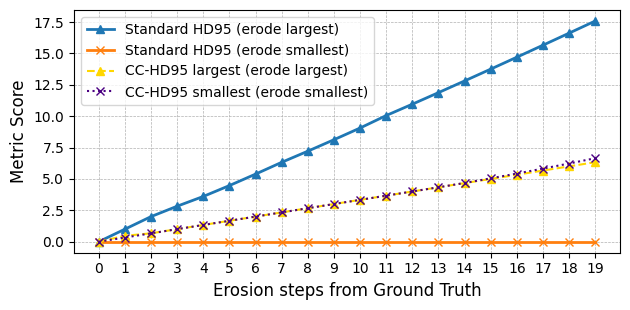

In [10]:
#Todo Put in first subplot
plt.figure(figsize=(6.4, 3.2))
plt.plot([x["Global_HausdorffDistance95"] for x in results_largest[:20]], label="Standard HD95 (erode largest)", linewidth=2, marker='^')
#plt.plot([x["Submetric_HausdorffDistance95_agg"] for x in results_largest[:20]], label="CC-HD95 largest (erode largest)", linewidth=2, marker='s',alpha=0.25)

#Todo Put in second subplot
plt.plot([x["Global_HausdorffDistance95"] for x in results[:20]], label="Standard HD95 (erode smallest)", linewidth=2, marker='x')
#plt.plot([x["Submetric_HausdorffDistance95_agg"] for x in results[:20]], label="Standard HD95 (erode smallest)", linewidth=2, marker='*')


plt.plot(
    [x["Submetric_HausdorffDistance_agg"] for x in results_largest[:20]],
    label="CC-HD95 largest (erode largest)",
    #linewidth=4,
    marker='^',
    color='Gold',  # Red color
    linestyle='--',
    #alpha=0.25
)

# Second subplot
plt.plot(
    [x["Submetric_HausdorffDistance_agg"] for x in results[:20]],
    label="CC-HD95 smallest (erode smallest)",
    #linewidth=2,
    marker='x',
    color='Indigo',  # Magenta color
    linestyle=':'
)

# Add gridlines
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Add legend with better placement
plt.legend(loc="best", fontsize=10, frameon=True)
plt.ylabel("Metric Score", fontsize=12)
# Set axis labels with larger fonts
#plt.ylabel("Metric Score", fontsize=12)
plt.xlabel("Erosion steps from Ground Truth", fontsize=12)

# Set x-ticks for the first 20 steps
plt.xticks(ticks=range(0, 20), labels=range(0, 20), fontsize=10)

# Set the plot's title
#plt.title("Comparison of Metrics over Erosion Steps", fontsize=14)

# Save the plot as a high-resolution image
plt.tight_layout()
#plt.savefig("HD_vs_HD_CC_small_small.pdf")